<a href="https://colab.research.google.com/github/applejxd/colaboratory/blob/master/OdeSolver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 前準備（万有引力の働く系）

万有引力が働く系
\begin{equation}
    m\ddot{\vec{r}}=-G\frac{Mm}{r^2}\vec{e}_r
    \Leftrightarrow
    \ddot{\vec{r}}=-\frac{GM}{r^2}\vec{e}_r
\end{equation}
を考える。
簡便のため $GM=1$ となるように単位系を取る。
このとき系を直交座標系に書き換えると
\begin{equation}
    \ddot{x}=-\frac{x}{(x^2+y^2)^{5/2}},\quad
    \ddot{y}=-\frac{y}{(x^2+y^2)^{5/2}}
\end{equation}
となる。
更にハミルトン系へと書き換えると
\begin{align}
    &\dot{q}_x=p_x,\quad
    \dot{p}_x=-\frac{q_x}{(q_x^2+q_y^2)^{3/2}},\\
    &\dot{q}_y=p_y,\quad
    \dot{p}_y=-\frac{q_y}{(q_x^2+q_y^2)^{3/2}}
\end{align}
となる。
エネルギーは運動の積分で
\begin{equation}
    E=\frac{1}{2}(p_x^2+p_y^2)-\frac{1}{(q_x^2+q_y^2)^{1/2}}
\end{equation}
である。


In [1]:
from typing import List, Callable
from numpy import ndarray

def dqxdt(x: ndarray) -> float:
    return x[2]

def dqydt(x: ndarray) -> float:
    return x[3]

def dpxdt(x: ndarray) -> float:
    return -x[0]/(x[0]**2 + x[1]**2)**1.5

def dpydt(x: ndarray) -> float:
    return -x[1]/(x[0]**2 + x[1]**2)**1.5

# 運動方程式
dxdt: List[Callable[[ndarray], float]] = [dqxdt,dqydt,dpxdt,dpydt]

## オイラー法

オイラー法は単純な差分近似
\begin{equation}
    \vec{x}(t+dt)
    \simeq\vec{x}(t)+\frac{d\vec{x}}{dt}(t,\vec{x}(t))dt
\end{equation}

In [2]:
import math
import numpy as np

def euler(dxdt: List[Callable[[ndarray], float]],
          init: ndarray, t_end: float) -> ndarray:
    # 次元チェック
    if len(dxdt) != len(init):
        raise Exception("Dimension error!")

    # ソルバーのパラメータ
    dt: float = 1e-2
    steps: List[int] = range(1, math.floor(t_end/dt), 1)

    # 初期状態
    x_list: ndarray = np.array([init])
    e_list: ndarray = np.array([(init[2]**2+init[3]**2)/2
                                -(init[0]**2+init[1]**2)**(-1/2)])
    # ソルバー実施
    for t in steps:
        x_next: ndarray = np.zeros(len(init))
        # オイラー法
        for k in range(len(init)):
            x_next[k] = x_list[-1][k] + dxdt[k](x_list[-1]) * dt
        # 結果を追加
        x_list = np.vstack((x_list,x_next))
        e_list = np.append(e_list,
            (x_next[2]**2+x_next[3]**2)/2-(x_next[0]**2+x_next[1]**2)**(-1/2))
        
    # 位置・運動量・エネルギーを戻り値として戻す
    return np.vstack((x_list.T, e_list))

軌道を計算して表示。誤差によって軌道が広がる。

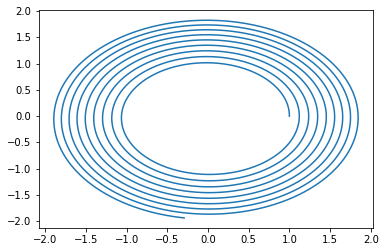

In [3]:
import matplotlib.pyplot as plt

ans: ndarray = euler(dxdt, np.array([1,0,0,1]), 100)
plt.plot(ans[0], ans[1])

誤差でエネルギーが上昇。

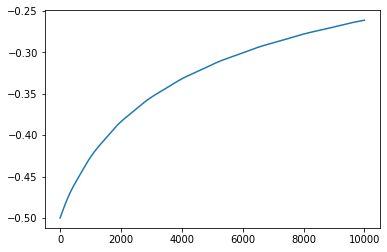

In [4]:
plt.plot(ans[4])

## ホイン法

ホイン法は次数 2 の 1 段階法。
\begin{equation}
\vec{k}_1\equiv\frac{d\vec{x}}{dt}(t,\vec{x}(t)),\quad
\vec{k}_2\equiv\frac{d\vec{x}}{dt}\left(t+dt,\vec{x}(t)+\vec{k}_1dt\right)
\end{equation}
とすれば
\begin{equation}
    \vec{x}(t+dt)
    \simeq\vec{x}(t)
    +(\vec{k}_1+\vec{k}_2)\frac{dt}{2}
\end{equation}

In [5]:
def heun(dxdt: List[Callable[[ndarray], float]],
          init: ndarray, t_end: float) -> ndarray:
    # 次元チェック
    if len(dxdt) != len(init):
        raise Exception("Dimension error!")

    # ソルバーのパラメータ
    dt: float = 1e-2
    steps: List[int] = range(1, math.floor(t_end/dt), 1)

    # 初期状態
    x_list: ndarray = np.array([init])
    e_list: ndarray = np.array([(init[2]**2+init[3]**2)/2
                                -(init[0]**2+init[1]**2)**(-1/2)])
    # ソルバー実施
    for t in steps:
        # ホイン法
        k: ndarray = np.zeros(len(init))
        for d in range(len(init)):
            k[d] = x_list[-1][d] + dxdt[d](x_list[-1]) * dt
        
        x_next: ndarray = np.zeros(len(init))
        for d in range(len(init)):
            x_next[d] = x_list[-1][d] + dt/2 * (dxdt[d](x_list[-1])+dxdt[d](k))
        
        # 結果を追加
        x_list = np.vstack((x_list,x_next))
        e_list = np.append(e_list,
            (x_next[2]**2+x_next[3]**2)/2-(x_next[0]**2+x_next[1]**2)**(-1/2))
        
    # 位置・運動量・エネルギーを戻り値として戻す
    return np.vstack((x_list.T, e_list))

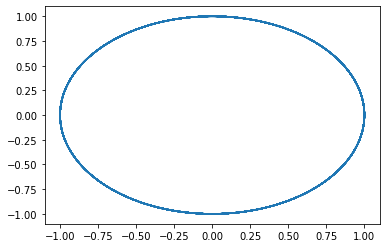

In [6]:
ans: ndarray = heun(dxdt, [1,0,0,1], 100)
plt.plot(ans[0], ans[1])

オイラー法と比較して誤差が低減する

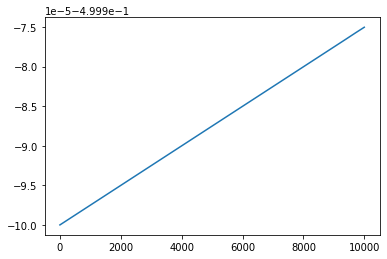

In [7]:
plt.plot(ans[4])

## ルンゲ・クッタ法

ルンゲ・クッタ法は次数 4 の 1 段階法。
\begin{align}
    &\vec{k}_1\equiv\frac{d\vec{x}}{dt}\left(t,\vec{x}\right),\\
    &\vec{k}_2\equiv\frac{d\vec{x}}{dt}\left(t+\frac{dt}{2},\vec{x}+\vec{k}_1\frac{dt}{2}\right),\\
    &\vec{k}_3\equiv\frac{d\vec{x}}{dt}\left(t+\frac{dt}{2},\vec{x}+\vec{k}_2\frac{dt}{2}\right),\\
    &\vec{k}_4\equiv\frac{d\vec{x}}{dt}\left(t+dt,\vec{x}+\vec{k}_3dt\right),
\end{align}
として
\begin{equation}
    \vec{x}(t+dt)
    \simeq\vec{x}(t)+(\vec{k}_1+2\vec{k}_2+2\vec{k}_3+\vec{k}_4)\frac{dt}{6}
\end{equation}

In [8]:
def rk4(dxdt: List[Callable[[ndarray], float]],
        init: ndarray, t_end: float) -> ndarray:
    # 次元チェック
    if len(dxdt) != len(init):
        raise Exception("Dimension error!")

    # ソルバーのパラメータ
    dt: float = 1e-2
    steps: List[int] = range(1, math.floor(t_end/dt), 1)

    # 初期状態
    x_list: ndarray = np.array([init])
    e_list: ndarray = np.array([(init[2]**2+init[3]**2)/2
                                -(init[0]**2+init[1]**2)**(-1/2)])
    # ソルバー実施
    for t in steps:
        # ホイン法
        k: ndarray = np.zeros((4, len(init)))
        for d in range(len(init)):
            k[0,d] = dxdt[d](x_list[-1])
        for d in range(len(init)):
            k[1,d] = dxdt[d](x_list[-1]+dt/2*k[0])
        for d in range(len(init)):
            k[2,d] = dxdt[d](x_list[-1]+dt/2*k[1])
        for d in range(len(init)):
            k[3,d] = dxdt[d](x_list[-1]+dt*k[2])
    
        x_next: ndarray = np.zeros(len(init))
        for d in range(len(init)):
            x_next[d] = x_list[-1][d] + dt * (k[0,d]+2*k[1,d]+2*k[2,d]+k[3,d])/6
        
        # 結果を追加
        x_list = np.vstack((x_list,x_next))
        e_list = np.append(e_list,
            (x_next[2]**2+x_next[3]**2)/2-(x_next[0]**2+x_next[1]**2)**(-1/2))
        
    # 位置・運動量・エネルギーを戻り値として戻す
    return np.vstack((x_list.T, e_list))

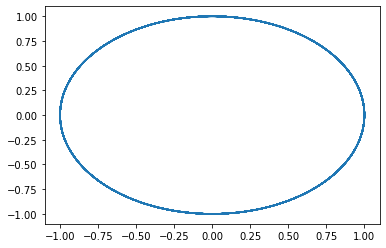

In [9]:
ans: ndarray = rk4(dxdt, [1,0,0,1], 100)
plt.plot(ans[0], ans[1])

誤差が更に低減するが、誤差の増大方向が逆

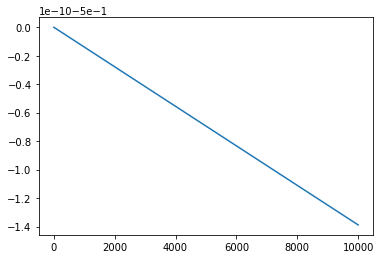

In [10]:
plt.plot(ans[4])

## リープ・フロッグ法

リープ・フロッグ法は中点差分による2段階法。
\begin{align}
    &\vec{q}(t+2dt)\simeq\vec{q}(t)+\vec{p}(t+dt)\cdot2dt,\\
    &\vec{p}(t+2dt)\simeq\vec{p}(t)+\frac{d\vec{p}}{dt}(t+dt)\cdot2dt
\end{align}
ハミルトン系では上記の特殊例として
\begin{align}
    &\vec{q}(t+dt/2)\simeq\vec{q}(t)+\frac{d\vec{q}}{dt}(p(t))dt/2,\\
    &\vec{p}(t+dt)\simeq\vec{p}(t)+\frac{d\vec{p}}{dt}(q(t+dt/2))dt,\\
    &\vec{q}(t+dt)\simeq\vec{q}(t+dt/2)+\frac{d\vec{q}}{dt}(p(t+dt))dt/2
\end{align}
も使われる。
この手法は 2 次のシンプレクティック積分に相当。

In [42]:
def leap_flog(dxdt: List[Callable[[ndarray], float]],
          init: ndarray, t_end: float) -> ndarray:
    # 次元チェック
    if len(dxdt) != len(init):
        raise Exception("Dimension error!")

    # ソルバーのパラメータ
    dt: float = 1e-2
    steps: List[int] = range(1, math.floor(t_end/dt), 1)

    # 初期状態
    x_list: ndarray = np.array([init])
    e_list: ndarray = np.array([(init[2]**2+init[3]**2)/2
                                -(init[0]**2+init[1]**2)**(-1/2)])
    # ソルバー実施
    for t in steps:
        # リープ・フロッグ法
        x_next: ndarray = np.zeros(len(init))

        x_next[0] = x_list[-1,0]+dxdt[0](x_list[-1])*dt/2
        x_next[1] = x_list[-1,1]+dxdt[1](x_list[-1])*dt/2

        x_next[2] = x_list[-1,2]+dxdt[2](x_next)*dt
        x_next[3] = x_list[-1,3]+dxdt[3](x_next)*dt

        x_next[0] = x_next[0]+dxdt[0](x_next)*dt/2
        x_next[1] = x_next[1]+dxdt[1](x_next)*dt/2
    
        # 結果を追加
        x_list = np.vstack((x_list,x_next))
        e_list = np.append(e_list,
            (x_next[2]**2+x_next[3]**2)/2-(x_next[0]**2+x_next[1]**2)**(-1/2))
        
    # 位置・運動量・エネルギーを戻り値として戻す
    return np.vstack((x_list.T, e_list))

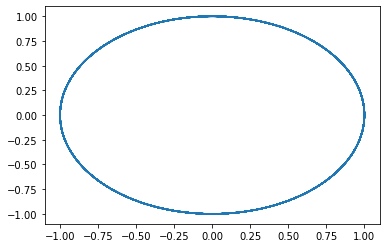

In [43]:
ans: ndarray = leap_flog(dxdt, [1,0,0,1], 100)
plt.plot(ans[0], ans[1])

エネルギーの誤差は振動。エネルギーが近似的に保存される。

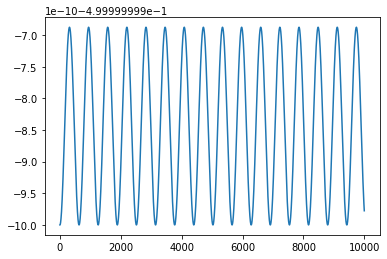

In [27]:
plt.plot(ans[4])

## アダムス・バッシュフォース法

## アダムス・ムルトン法